In [1]:
import sys
import os

import numpy as np
import matplotlib.pyplot as plt


sys.path.append(os.path.abspath("py/"))
import freddie_segment_and_cluster as fred
import freddie_ilp as ilp

In [2]:
for tint_lines in fred.generate_tint_lines("output/results/N1_debug/freddie.split"):
    tint = fred.Tint(tint_lines)
    if 267 < (N := len(tint.reads)) < 300:
        print(N)
        break

281


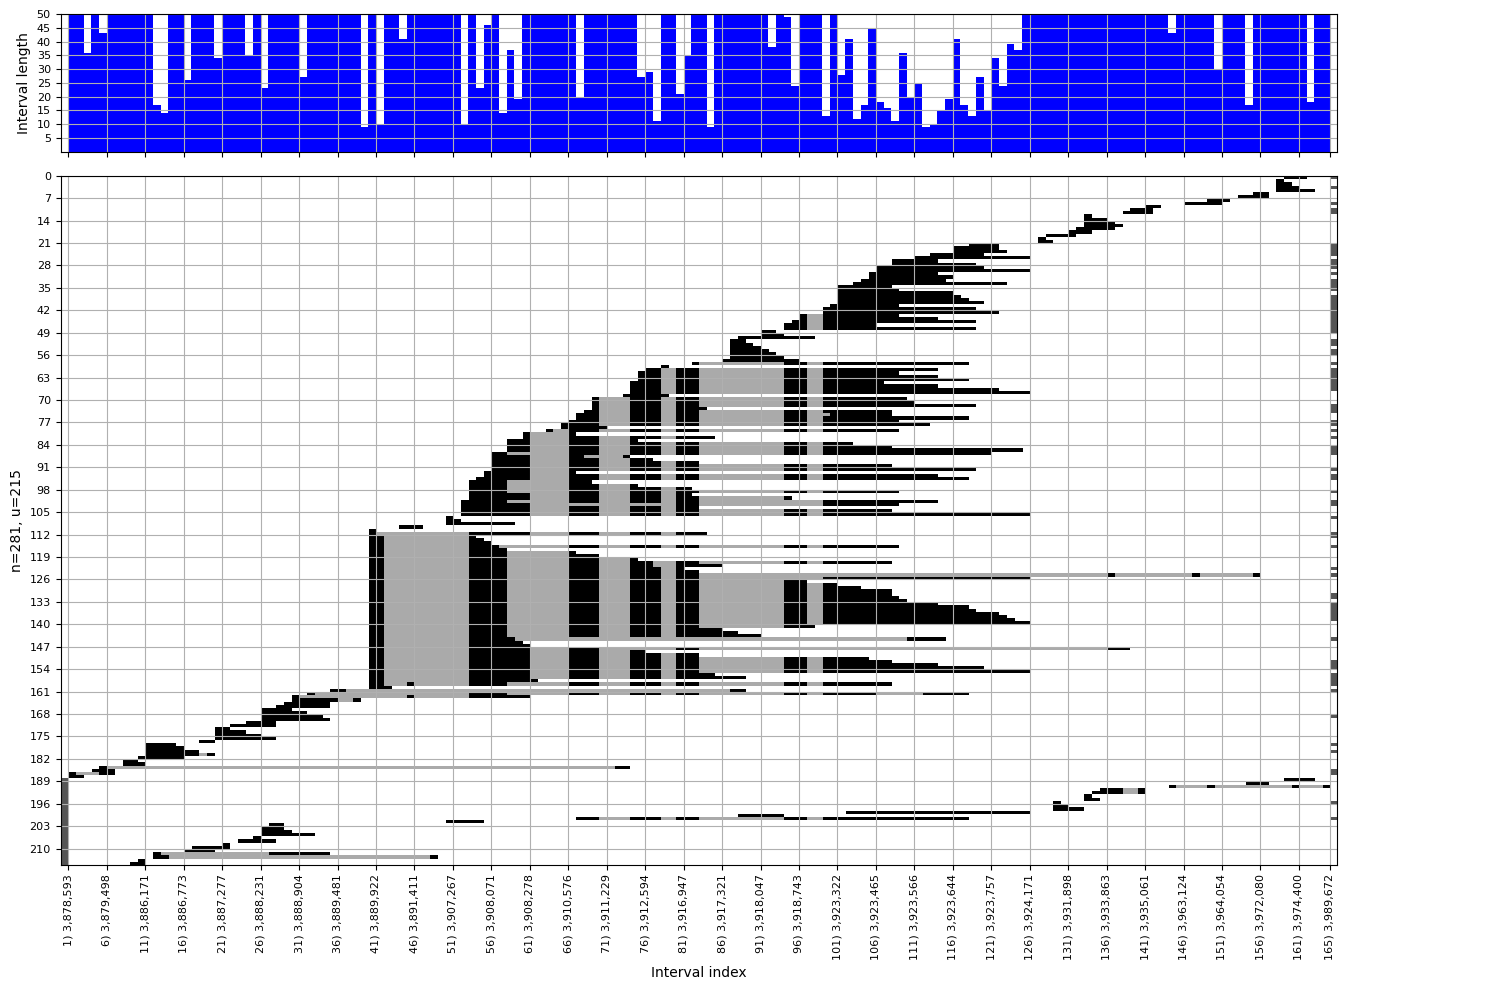

In [3]:
cints = fred.canonInts(tint.reads)
for i in range(10):
    cints.pop(i)
cints.plot()

In [4]:
I = ilp.FredILP(cints)
I.build_model()

In [5]:
status, cost, read_bins = I.solve(solver="GUROBI", timeLimit=60*15, threads=32)
cost, tuple(map(len, read_bins))

Set parameter Username
Academic license - for non-commercial use only - expires 2024-10-13


(930.0, (231, 50))

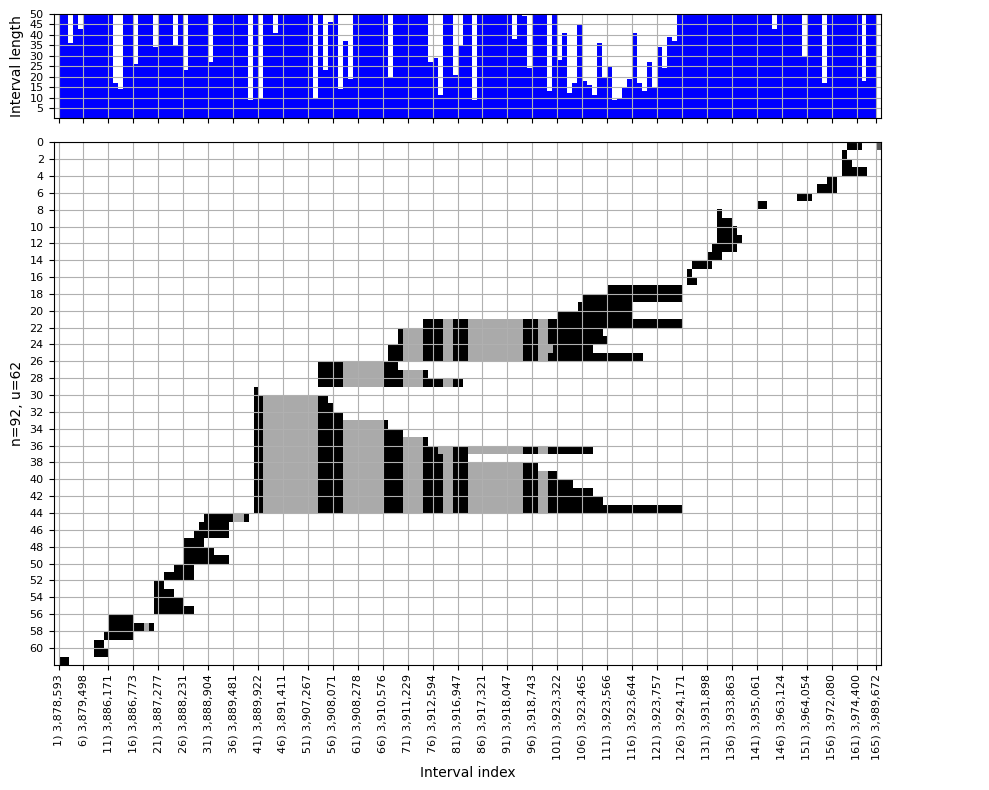

In [22]:
cints.plot(figsize=(10, 8), unique=True, read_bins=read_bins[:])

In [24]:
from collections import defaultdict, Counter

variables = defaultdict(dict)
for V in I.model.variables():
    name = V.getName()
    table, index = name.split("_")
    index_vals = list()
    for n in index.split(","):
        if n.startswith("n"):
            n = f"-{n[1:]}"
        index_vals.append(int(n))
    index_vals = tuple(index_vals)
    variables[table][index_vals] = round(V.value())

In [25]:
covered = set()
M = len(I.rows[0])
for i, row in enumerate(I.rows):
    if variables["R2I"][i, 1] == 0:
        continue
    min_j = M + 1
    max_j = -1
    for j in range(M):
        if variables["C2IR"][j, 1, i]:
            min_j = min(min_j, j)
            max_j = max(max_j, j)
    covered.update(range(min_j, max_j + 1))
for j in range(M):
    assert variables["C2I"][j, 1] == 0 or j in covered, (j, variables["C2I"][j, 1])
#     if j not in covered:
#         print(j)
# print(covered)

AssertionError: (0, 1)

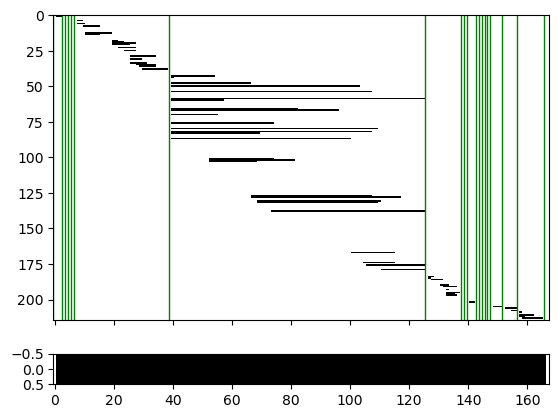

In [49]:
N = len(I.rows)
M = len(I.rows[0])
fig, axes = plt.subplots(2, gridspec_kw={"height_ratios": [10, 1]}, sharex=True)
arr = np.zeros((N, M + 2), dtype=int)
for (j, k, i), val in variables["C2IR"].items():
    if k != 1:
        continue
    arr[i, j] = val

axes[0].imshow(arr, aspect="auto", cmap="Greys", interpolation="none")
for j in range(-1, M + 1):
    if 1 not in np.unique(arr[:, j]):
        axes[0].axvline(j - 0.5, color="green", lw=1)

arr = np.zeros((1, M + 2), dtype=int)
for (j, k), val in variables["C2I"].items():
    if k != 1:
        continue
    arr[0, j + 1] = val
axes[1].imshow(arr, aspect="auto", cmap="Greys", interpolation="none")

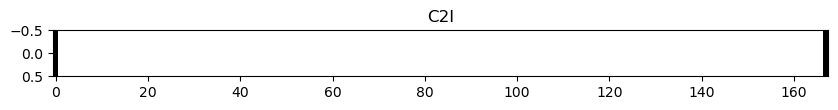

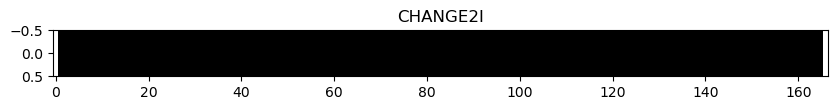

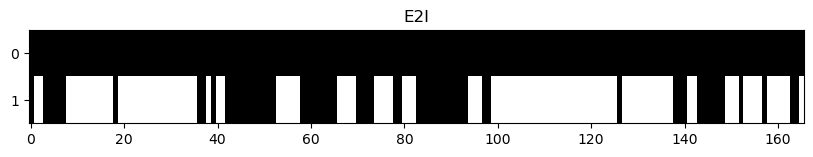

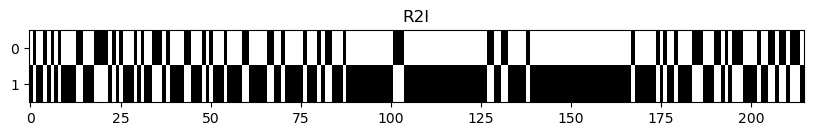

In [26]:

for table_name, table in variables.items():
    index = next(iter(table.keys()))
    mins = [x for x in index]
    maxs = [x for x in index]
    for index in table.keys():
        for i, j in enumerate(index):
            if j < mins[i]:
                mins[i] = j
            if j > maxs[i]:
                maxs[i] = j
    A = np.zeros([maxs[i] - mins[i] + 1 for i in range(len(mins))])
    for index, value in table.items():
        A[tuple([x - y for x, y in zip(index, mins)])] = value + 10
    if len(A.shape) != 2:
        continue
    # # drop any dimensions that are 1 from A
    # A = A.squeeze()
    plt.figure(figsize=(10, 8))
    plt.title(table_name)
    # imshow with y-axis 5 times larger than x-axis
    plt.imshow(A.T, aspect=10, interpolation="none", cmap="gray")

In [155]:
for ridxs in I.ridxs:
    assert len({B.get_matrix()[ridx].sum() for ridx in ridxs}) == 1

In [151]:
B.get_matrix()[0].sum()

38

605 271


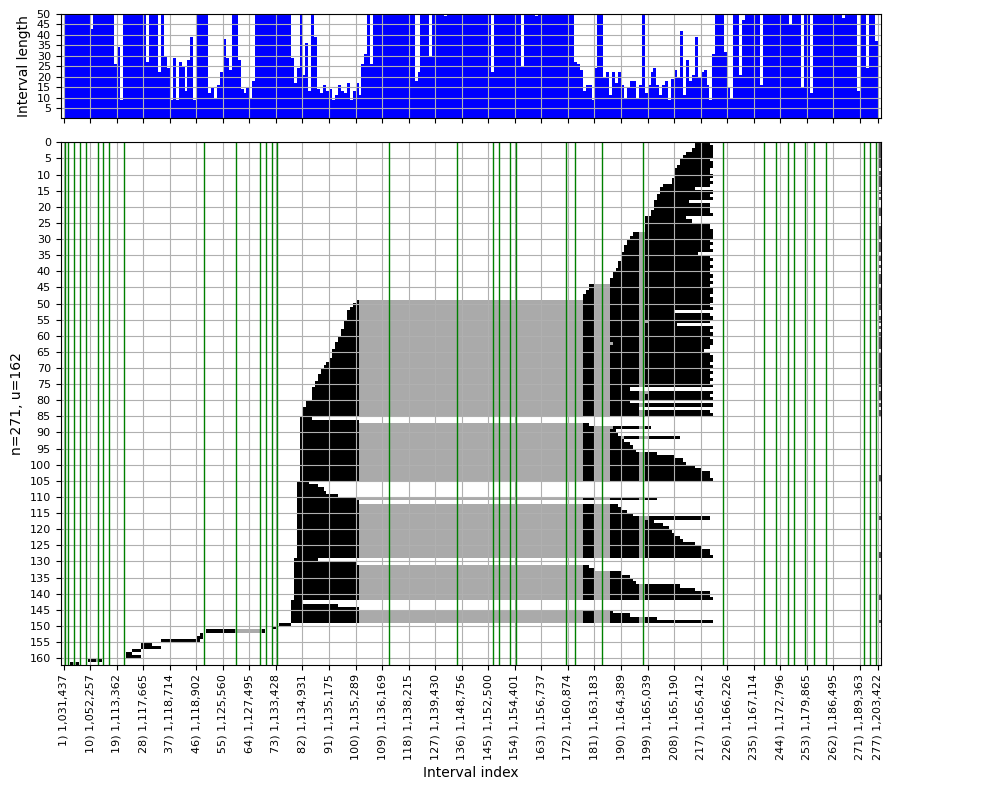

In [156]:
new_bins = [[], []]
for (i, k), val in variables["R2I"].items():
    if val > 0.5:
        new_bins[k].extend(I.ridxs[i])
print(*map(len, new_bins))
B.plot(figsize=(10, 8), unique=True, read_bins=new_bins[1:])

In [119]:
(*map(len, read_bins),)

(605, 271)

In [121]:
for i, 

547

In [98]:
j = 125
for (i, k), val in variables["R2I"].items():
    if k != 1:
        continue
    if val < 0.5:
        continue
    for ridx in I.ridxs[i]:
        assert ridx in read_bins[k]
    a = I.rows[i][j]
    b = B.intervals[j]._ridx_to_type.get(ridx, fred.canonInts.aln_type.unaln)
    assert a == b

In [65]:
A = np.zeros(())
for index, val in sorted(variables["OBJ"].items()):
    i, j, k = index
    if variables["R2I"][i, k] < 0.5:
        continue
    if not 125 < j < 150:
        continue
    assert k == 1
    print(
        i,
        j,
        round(val),
        round(variables["E2I"][j, k]),
        round(variables["R2I"][i, k]),
    )

194 126 0 0 1
194 127 0 0 1
194 128 0 0 1
194 129 0 0 1
194 130 0 0 1
194 131 0 0 1
194 132 0 0 1
194 133 0 0 1
194 134 0 0 1
194 135 0 0 1
194 136 0 0 1
194 137 0 0 1
194 138 0 0 1
194 139 0 0 1
194 140 0 0 1
194 141 0 0 1
194 142 0 0 1
194 143 0 0 1
194 144 0 0 1
194 145 0 0 1
194 146 0 0 1
194 147 0 0 1
194 148 0 0 1
194 149 0 0 1
199 126 0 0 1
199 127 0 0 1
199 128 0 0 1
199 129 0 0 1
199 130 0 0 1
199 131 0 0 1
199 132 0 0 1
199 133 0 0 1
199 134 0 0 1
199 135 0 0 1
199 136 0 0 1
199 137 0 0 1
199 138 0 0 1
199 139 0 0 1
199 140 0 0 1
199 141 0 0 1
199 142 0 0 1
199 143 0 0 1
199 144 0 0 1
199 145 0 0 1
199 146 0 0 1
199 147 0 0 1
199 148 0 0 1
199 149 0 0 1
201 126 0 0 1
201 127 0 0 1
201 128 0 0 1
201 129 0 0 1
201 130 0 0 1
201 131 0 0 1
201 132 0 0 1
201 133 0 0 1
201 134 0 0 1
201 135 0 0 1
201 136 0 0 1
201 137 0 0 1
201 138 0 0 1
201 139 0 0 1
201 140 0 0 1
201 141 0 0 1
201 142 0 0 1
201 143 0 0 1
201 144 0 0 1
201 145 0 0 1
201 146 0 0 1
201 147 0 0 1
201 148 0 0 1
201 14